## Step 1: Load Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


## Step 2: Load & Clean the Dataset

In [5]:


# Load and fix column names
df = pd.read_csv("C:\\Users\\HP\\Downloads\\archive (2)\\Credit Card Defaulter Prediction.csv")
df.columns = df.columns.str.strip()  # Remove whitespace

# Convert target column 'default' to binary
df['default'] = df['default'].map({'N': 0, 'Y': 1})

print(df['default'].value_counts())




default
0    23364
1     6636
Name: count, dtype: int64


## Step 3: Encode Categorical Columns

In [8]:
# Label encode categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])



## Step 4: EDA (Class Balance, Correlation)

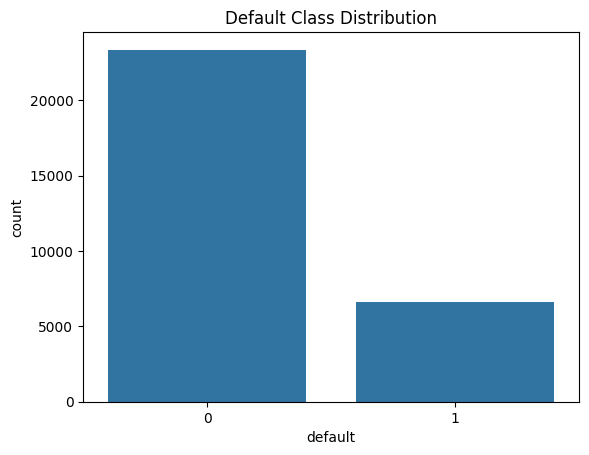

In [11]:
# Class Distribution
sns.countplot(data=df, x='default')
plt.title('Default Class Distribution')
plt.show()

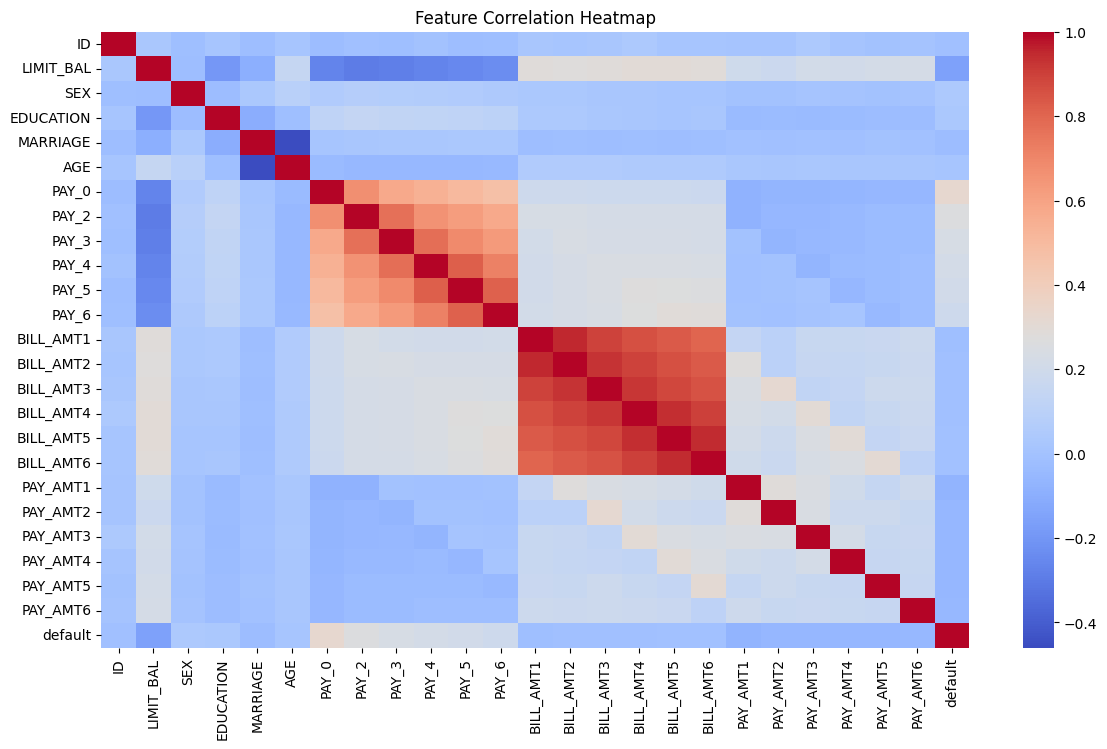

In [13]:
# Correlation Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## Step 5: Split and Scale the Data

In [16]:
X = df.drop("default", axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 6: Balance Classes using SMOTE

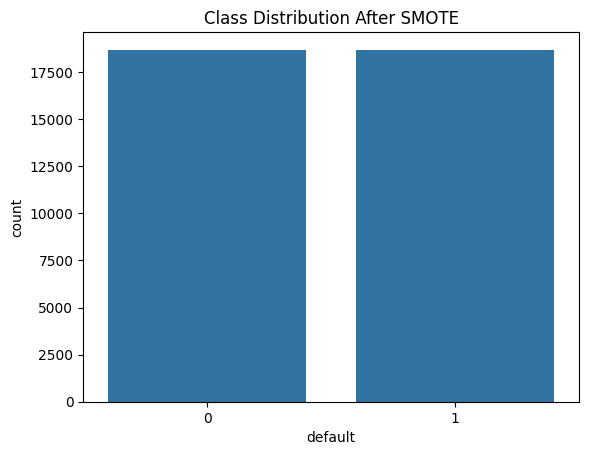

In [19]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

sns.countplot(x=y_train_bal)
plt.title("Class Distribution After SMOTE")
plt.show()

## Step 7: Train Logistic Regression Model

In [22]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test_scaled)


## Step 8: Evaluate Model Performance

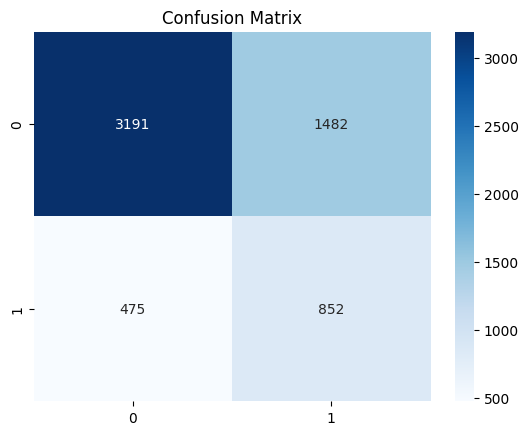

In [25]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.77      4673
           1       0.37      0.64      0.47      1327

    accuracy                           0.67      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.67      0.70      6000



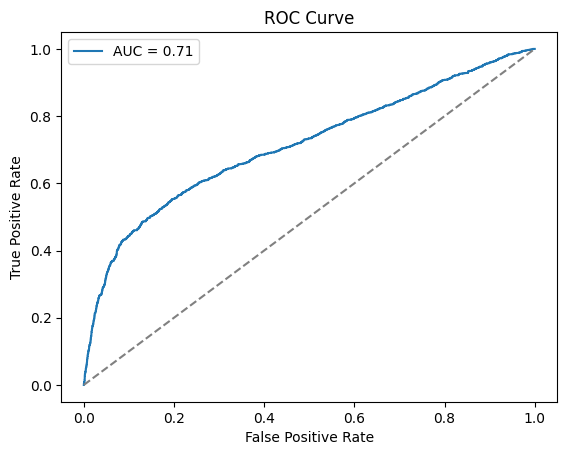

In [29]:
# ROC Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Step 9: Feature Importance

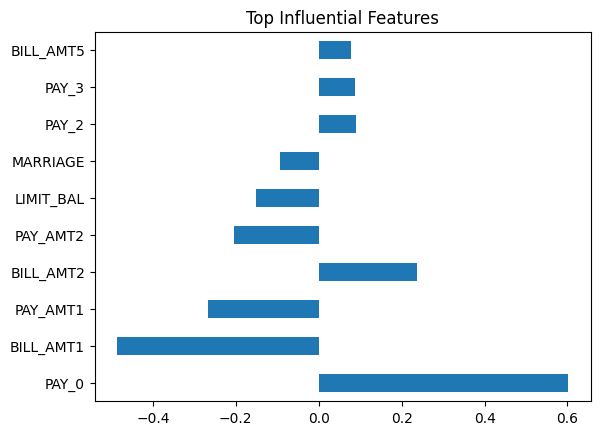

In [32]:
coeffs = pd.Series(model.coef_[0], index=X.columns)
top_features = coeffs.sort_values(key=abs, ascending=False).head(10)

top_features.plot(kind='barh')
plt.title("Top Influential Features")
plt.show()


## Step 10: Dashboard / Scorecard (Simplified)

In [35]:
# 1. Add Predictions to Your DataFrame
# Predict on scaled test set
df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = model.predict(X_test_scaled)
df_test['predicted_proba'] = model.predict_proba(X_test_scaled)[:, 1]

In [37]:
# 2. Default Summary Table

summary = df_test.groupby('predicted').agg({
    'LIMIT_BAL': ['mean', 'count'],
    'AGE': 'mean',
    'predicted_proba': 'mean'
}).round(2)

print("🔍 Prediction Summary Scorecard")
print(summary)

🔍 Prediction Summary Scorecard
           LIMIT_BAL          AGE predicted_proba
                mean count   mean            mean
predicted                                        
0          214382.89  3666  35.22            0.34
1           95051.41  2334  36.44            0.64


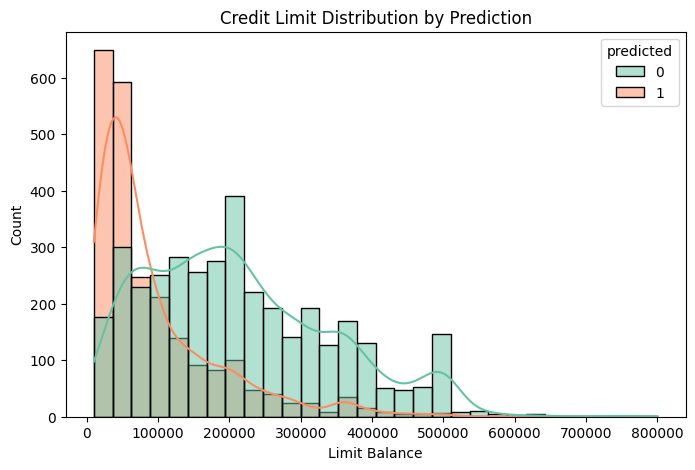

In [39]:
# 3. Visualize Risk by Credit Limit
plt.figure(figsize=(8, 5))
sns.histplot(data=df_test, x='LIMIT_BAL', hue='predicted', bins=30, kde=True, palette='Set2')
plt.title('Credit Limit Distribution by Prediction')
plt.xlabel('Limit Balance')
plt.ylabel('Count')
plt.show()

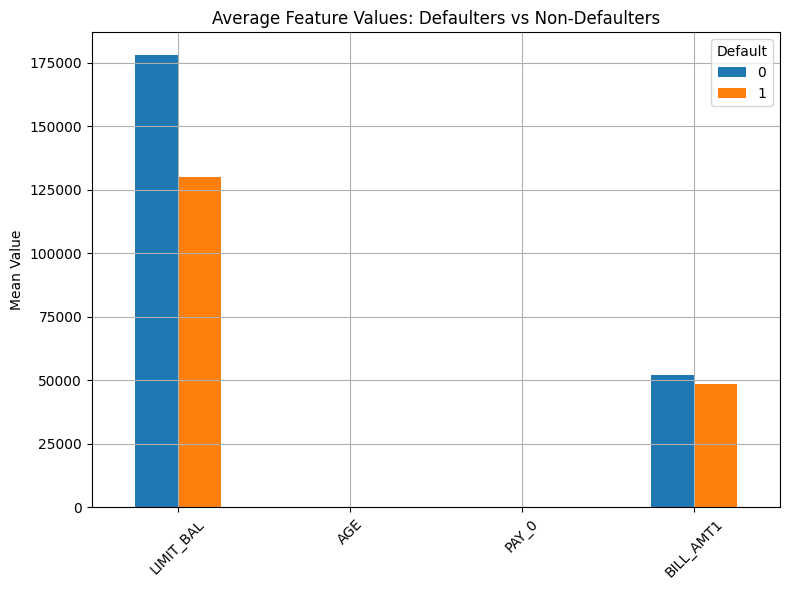

In [41]:
# 4. Average Feature Comparison
default_summary = df.groupby('default')[['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1']].mean().T

default_summary.plot(kind='bar', figsize=(8,6))
plt.title("Average Feature Values: Defaulters vs Non-Defaulters")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.legend(title='Default')
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
#  5. Scorecard Table (Manual Lending Insight)
scorecard = df_test[['LIMIT_BAL', 'AGE', 'predicted_proba', 'predicted']].copy()
scorecard['Decision'] = scorecard['predicted_proba'].apply(lambda x: 'Decline' if x > 0.6 else 'Approve')
print(scorecard.head(10))

       LIMIT_BAL  AGE  predicted_proba  predicted Decision
6907       50000   46         0.288223          0  Approve
24575     150000   31         0.354663          0  Approve
26766      50000   25         0.506465          1  Approve
2156      290000   25         0.269910          0  Approve
3179      500000   27         0.103461          0  Approve
29382     200000   29         0.348456          0  Approve
24454     210000   31         0.308240          0  Approve
23886     260000   35         0.417893          0  Approve
5504      450000   42         0.200792          0  Approve
29720     150000   39         0.489611          0  Approve
